# Testing Wavelength Calibration

In [1]:
from ccdproc import (CCDData, ImageFileCollection)
from scipy import (signal, interpolate)
import os
import glob
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits.header import Header

import sys
sys.path.append('/user/simon/development/soar/goodman')

# import goodman
from pipeline.core import (read_fits, write_fits)
from pipeline.wcs.wcs import WCS

plt.rcParams["figure.figsize"] = [16,9]


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]
[05:26:05PM][    INFO]: Starting Goodman HTS Pipeline Log
[05:26:05PM][    INFO]: Local Time    : 2018-06-14 17:26:05.449582
[05:26:05PM][    INFO]: Universal Time: 2018-06-14 21:26:05.450126
[05:26:05PM][    INFO]: Pipeline Version: 1.0.1


## Read Data Calibrated Automatically

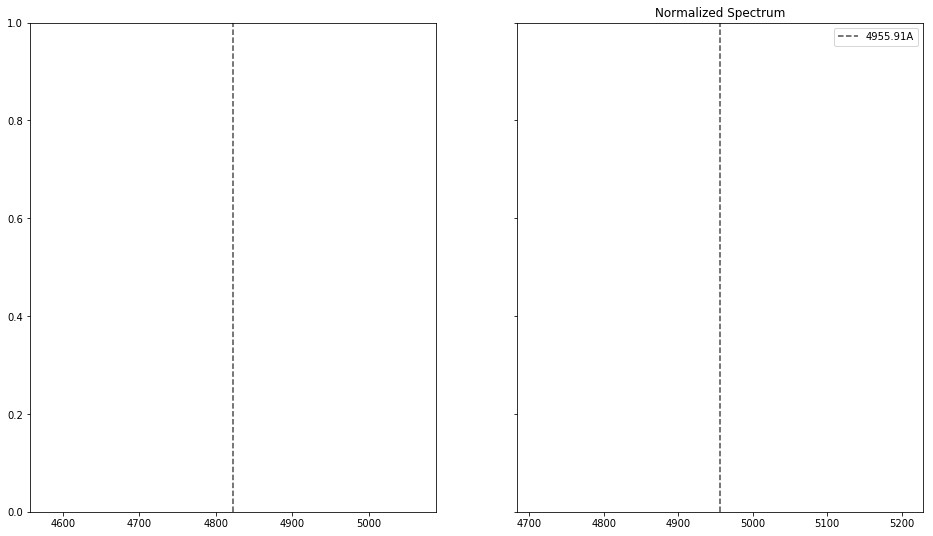

In [2]:
def normalize_data(data):
    return data/np.mean(data)

def aller_test(image_list):
    wcs = WCS()
    assert isinstance(wcs, WCS)
    all_data = []
    all_dates = []
    for file_name in image_list:
    
        ccd = CCDData.read(file_name, unit=u.adu)
        print("Master Flat used: {:s}".format(ccd.header['GSP_FLAT']))
        print("{:s} : {:s}".format(ccd.header['DATE-OBS'], file_name))
        # print(ccd.header["GSP_*"])
        wav, intens = wcs.read(ccd=ccd)
        all_data.append([wav, normalize_data(intens), ccd.header])
        all_dates.append(ccd.header['DATE'])
        plt.title(file_name)
        plt.plot(wav, normalize_data(intens))
        plt.xlabel("Wavelength (Angstrom)")
        plt.ylabel("Intensity (ADU)")
        plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    
    plt.title("Normalized Spectrum")
    ax1.axvline(4822.3787, label='4822.3787A', color='k', linestyle='--', alpha=0.7)
    ax2.axvline(4955.91, label='4955.91A',color='k', linestyle='--', alpha=0.7)
    for i in range(len(all_data)):
        ax1.plot(all_data[i][0], all_data[i][1], label=all_dates[i])
        ax1.set_xlim(4817, 4855)
        # ax1.axvline(4822.3787, label='4822.3787A', color='k', linestyle='--')
        ax2.plot(all_data[i][0], all_data[i][1], label=all_dates[i])
        ax2.set_xlim(4951, 5000)
        
        ax1.set_xlabel("Wavelength (Angstrom)")
        ax1.set_ylabel("Intensity (ADU)")
        ax1.legend(loc='best')

    plt.legend(loc='best')
    plt.show()
    return all_data


files = glob.glob('./data/w*HD*fits')

all_data = aller_test(image_list=files)

    

![Flux](img/RVstd_flux_TwoLines_ThreeNights.png)
![RV](img/RVstd_goodman_beta1.png)

# The Comparison Lamps

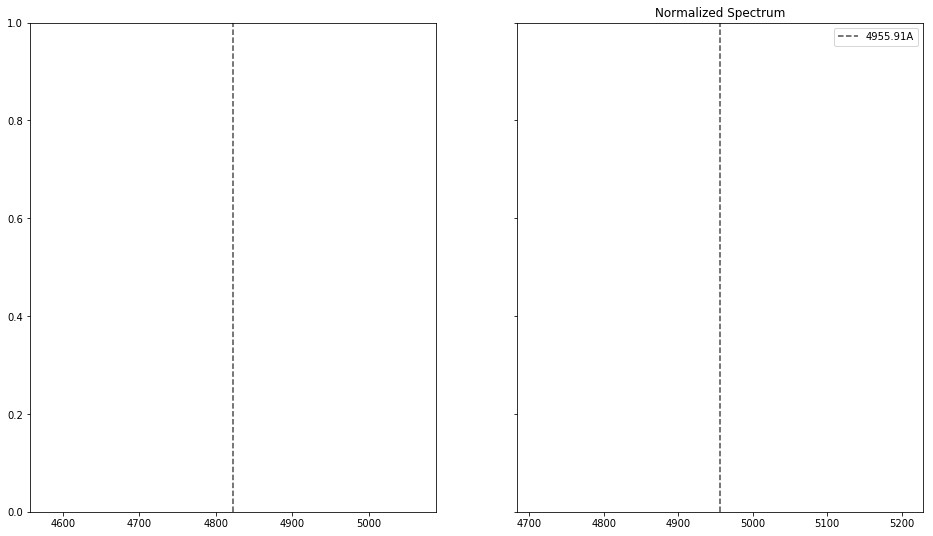

In [3]:
lamp_files = glob.glob("./data/g*Cu*fits")

all_lamps = aller_test(lamp_files)



In [4]:
fig2, axes = plt.subplots(8, 2, figsize=(16, 30))
limits = np.linspace(0, len(all_lamps[0][1])-1, 17)
all_limits = [[int(limits[i]), int(limits[i + 1])] for i in range(0, len(limits)-1, 1)]
print(all_limits)

for lamp in all_lamps:
    z=0
    for i in range(8):
        for e in range(2):
            # print(i, e)
            # print(i * e, i * e +1)
            # print(all_limits[z])
            axes[i, e].plot(lamp[0], lamp[1], label = "{:s}".format(lamp[2]['DATE']))
            axes[i, e].set_xlim((all_lamps[0][0][all_limits[z][0]], all_lamps[0][0][all_limits[z][1]]))
            axes[i, e].legend(loc='best')

            z += 1
#     for ax in sub_ax:
#         ax.plot(all_lamps[0])

plt.show()

# for lamp in all_lamps:
#     plt.plot(lamp[0], lamp[1])
# plt.show()

IndexError: list index out of range

![Flux](img/RVstd_flux_TwoLines_ThreeNights.png)

# Attempt to extract from Data

In [ ]:
sys.path.append('/user/simon/development/soar/goodman')

# import goodman
from pipeline.core import identify_targets, trace ,extraction, read_fits
from astropy.modeling import models, fitting
import glob
# from goodman.pipeline.core import extraction

plt.rcParams["figure.figsize"] = [16,9]
n_sigmas = 3

images = glob.glob("./data/c*HDfits")

def extract_from_file(image_list, clim=None):
    all_traces = []
    dispersion = 0
    for image in image_list:
        ccd = read_fits(image)
        spatial, dispersion = ccd.data.shape
        print(spatial, dispersion)
    
        target = identify_targets(ccd=ccd)
        print(target[0])
        trace_model  = models.Polynomial1D(degree=2)
        trace_fitter = fitting.LevMarLSQFitter()

        traces = trace(ccd=ccd,
                       model=target[0],
                       trace_model=trace_model,
                       model_fitter=trace_fitter,
                       sampling_step=5)
        all_traces.append([traces, image])
        print(traces)
        extracted= extraction(ccd=ccd,
                              target_trace=traces,
                              spatial_profile=target[0],
                              extraction_name='fractional')
        # print(traces)
    
    
        print(np.median(ccd.data), np.mean(ccd.data))
        plt.title(image)
        plt.plot(traces(range(dispersion)), color='r')
        if clim is None:
            clim = (0.3 * np.median(ccd.data), 0.3 * np.mean(ccd.data))
        plt.imshow(ccd.data, clim=clim)
        plt.show()
    
        plt.plot(extracted.data)
        plt.show()
    for single_trace, image in all_traces:
        plt.plot(single_trace(range(dispersion)), label=image)
    plt.legend(loc='best')
    plt.title("Target Traces")
    plt.xlabel("Dispersion Axis")
    plt.ylabel("Spatial Axis")
    plt.show()

extract_from_file(image_list=images)

# From Raw Data

In [5]:
raw_data = glob.glob("./data/0*fits")

extract_from_file(image_list=raw_data, clim=(500, 1000))

NameError: name 'extract_from_file' is not defined

INFO: 04:02:13PM: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: 04:02:13PM: Reading Linear Solution


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Master Flat used: norm_master_flat_1200m2_1.03_dome.fits
2017-06-12T09:00:43.783 : ./last/gcfzsto_0171_HD177409_G1200M2_slit103.fits


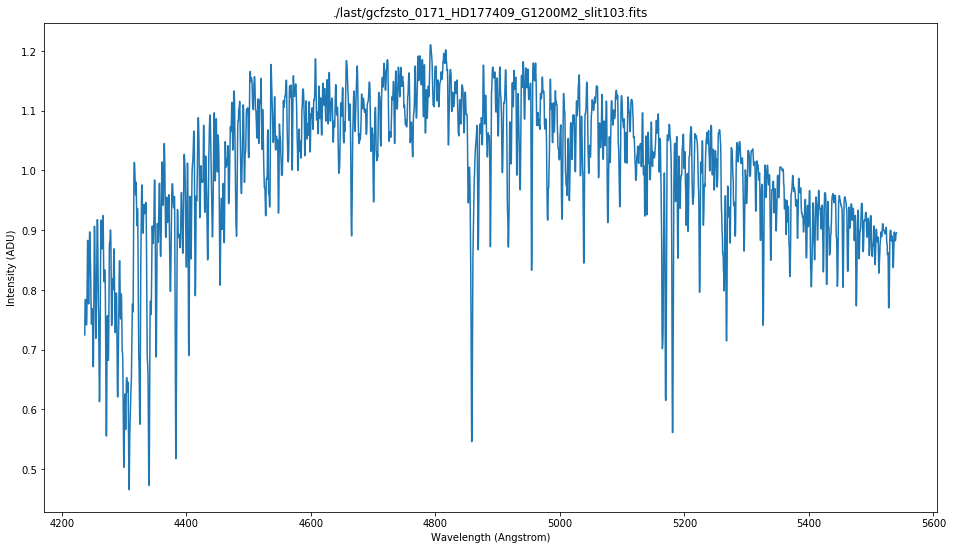

INFO: 04:02:13PM: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: 04:02:13PM: Reading Linear Solution


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Master Flat used: norm_master_flat_HD177409_1200m2_1.03_sky.fits
2017-06-13T10:29:31.049 : ./last/int_HD177409.fits


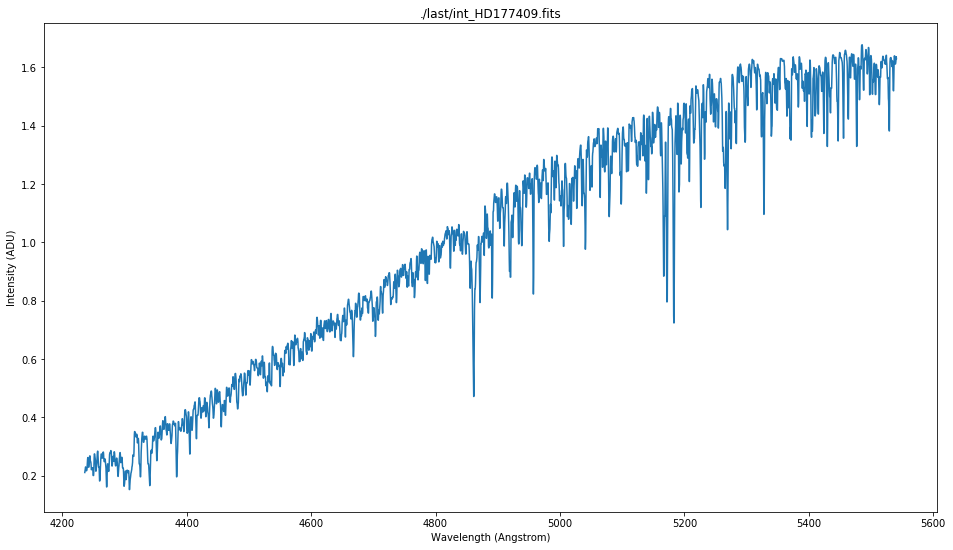

INFO: 04:02:13PM: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: 04:02:13PM: Reading Linear Solution


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Master Flat used: norm_master_flat_HD177409_1200m2_1.03_sky.fits
2017-06-13T10:29:31.049 : ./last/gcfzsto_0085_HD177409_G1200M2_slit103.fits


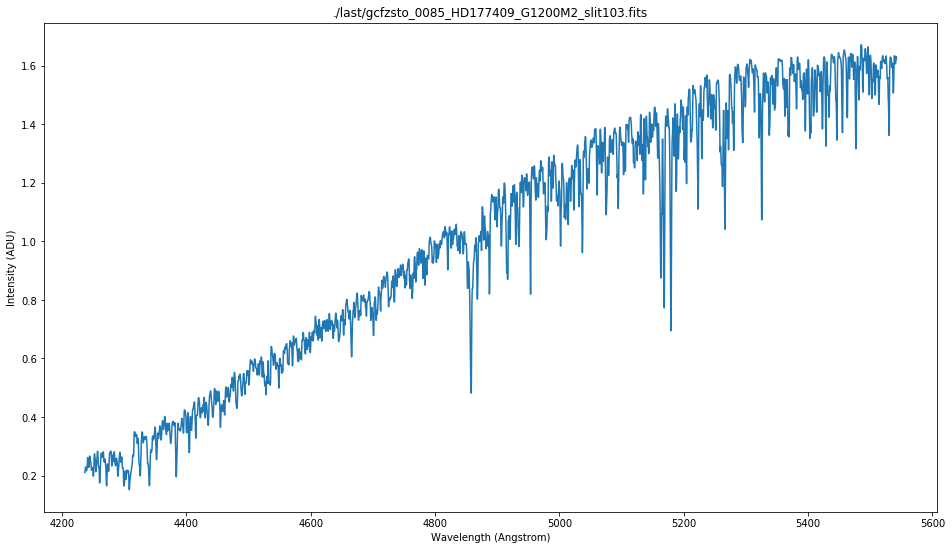

INFO: 04:02:14PM: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: 04:02:14PM: Reading Linear Solution


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Master Flat used: norm_master_flat_1200m2_1.03_dome.fits
2017-06-11T08:38:56.186 : ./last/gcfzsto_0109_HD177409_G1200M2_slit103.fits


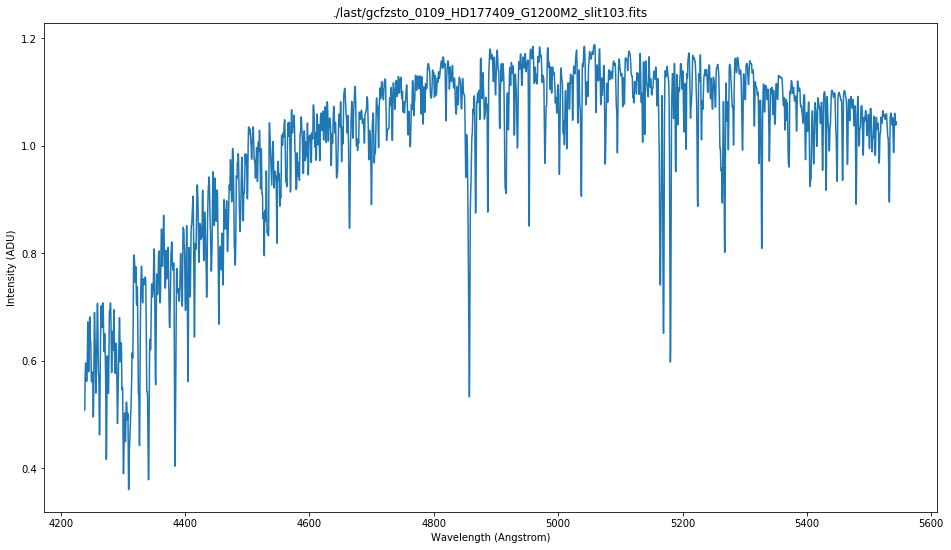

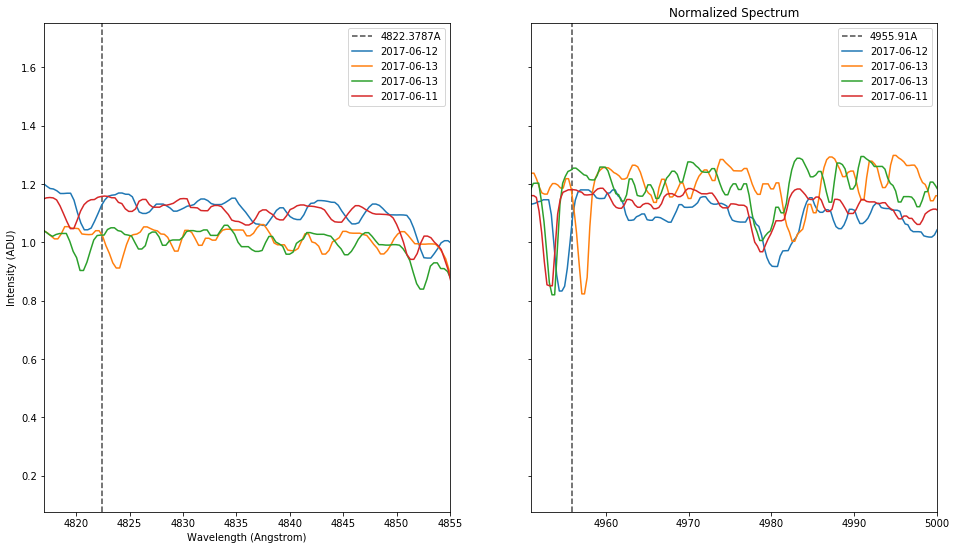

In [17]:
last_data = glob.glob("./last/*fits")

data = aller_test(last_data)


In [18]:
from astropy import constants
# print(constants.c)
kms = u.km / u.s


# print(constants.c)
kms = u.km / u.s


def rv_value(rest, measured):
    print("Shift for {:s}: {:s}".format(str(rest.value), str(rest.value - measured)))
    rv = ((measured - rest.value)/rest.value) * constants.c.value
    # print(rv * constants.c.unit)
    rm_ms = rv * constants.c.unit
    return rm_ms.to(kms)
def rv_value(rest, measured):
    print("Shift for {:s}: {:s}".format(str(rest.value), str(rest.value - measured)))
    rv = ((measured - rest.value)/rest.value) * constants.c.value
    # print(rv * constants.c.unit)
    rm_ms = rv * constants.c.unit
    return rm_ms.to(kms)

Shift for 4822.3787: -1.163300000000163
Shift for 4955.91: -0.9239999999999782
Shift for 4822.3787: -0.8442999999997483
Shift for 4955.91: -0.6580000000003565
Shift for 4822.3787: -1.5922999999993408
Shift for 4955.91: -1.4650000000001455


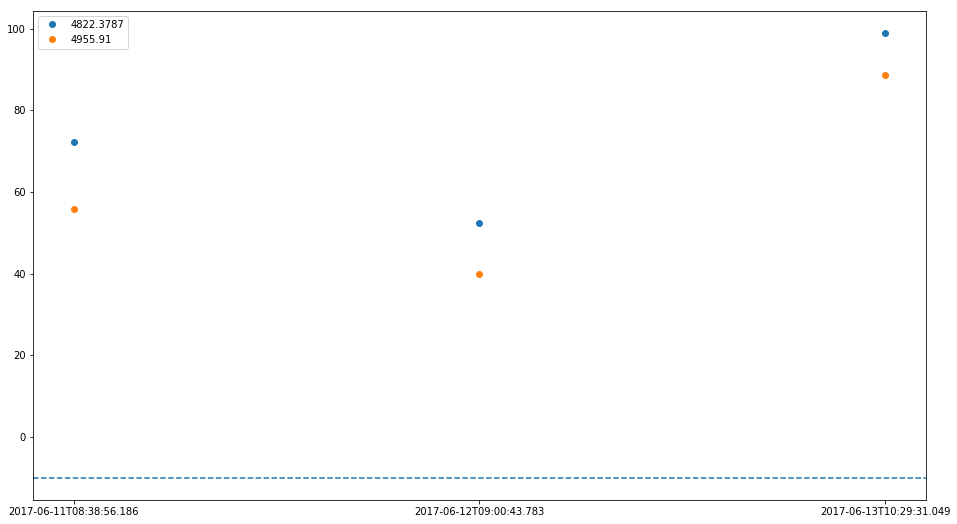

In [19]:
ref_line_1 = 4822.3787 * u.angstrom
ref_line_2 = 4955.91 * u.angstrom

dates = ['2017-06-11T08:38:56.186', '2017-06-12T09:00:43.783', '2017-06-13T10:29:31.049']
   
first_line = [4823.542, 4823.223, 4823.971]
second_line = [4956.834, 4956.568, 4957.375]
rv_1 = []
rv_2 = []

for i in range(len(dates)):
    rv1 = rv_value(rest=ref_line_1, measured=first_line[i])
    rv_1.append(rv1.value)
    
    rv2 = rv_value(rest=ref_line_2, measured=second_line[i])
    rv_2.append(rv2.value)

plt.plot(dates, rv_1, label=ref_line_1.value, marker='o', linestyle='')
plt.plot(dates, rv_2, label=ref_line_2.value, marker='o', linestyle='')
plt.axhline(-10, linestyle='--')
plt.legend(loc='best')
plt.show()


![Flux](img/RVstd_flux_TwoLines_ThreeNights.png)
![RV](img/RVstd_goodman_beta1.png)

$$
\begin{equation*}
V_R = \frac{\Delta \lambda}{\lambda} * c = \frac{\lambda_{meas} - \lambda_{ref}}{\lambda_{ref}} * c
\end{equation*}
$$

Therefore 

$$
\begin{equation*}
\Delta \lambda = \frac{V_R * \lambda}{c}
\end{equation*}
$$

In [26]:
rv = -10 * (u.km / u.s)
ms = u.m / u.s

value1 = (ref_line_1 * (rv.to(ms)) / constants.c) + ref_line_1
value2 = (ref_line_2 * (rv.to(ms)) / constants.c) + ref_line_2
print(value1, value2)

4822.217842761223 Angstrom 4955.744688636497 Angstrom


In [21]:
print((-10 * (u.km / u.s) / constants.c.to('km/s')) * ref_line_1)
print((-10 * (u.km / u.s) / constants.c.to('km/s')) * ref_line_2)

-0.16085723877683408 Angstrom
-0.16531136350334738 Angstrom
